# ⚡️ 5 Minutes Guide

Writing a Trace program involves three steps.

1. Write a normal python program.
2. Decorate the program with Trace primitives: `node` and `@bundle`.
3. Use a Trace Graph-compatible optimizer to optimize the program.

## Start with a Normal Python Program

To illustrate the fundamental difference between Trace and many other LLM libraries, we can look at a coding problem from OpenAI's Human-Eval dataset. 

In [13]:
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    lst = sorted(lst)
    return lst

In [14]:
strange_sort_list([1, 2, 3, 4])

[1, 2, 3, 4]

Our first attempt is not very successful -- we tried one of the example input and the output is not correct. Can we leverage an LLM to help us automatically figure out the right solution?

## Trace this Program

We use decorators like `@bundle` to wrap over Python functions. A **bundled** function behaves like any other Python functions.

In [4]:
from opto.trace import node, bundle

@bundle(trainable=True)
def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    lst = sorted(lst)
    return lst

test_input = [1, 2, 3, 4]
test_output = strange_sort_list(test_input)
print(test_output)

MessageNode: (eval:1, dtype=<class 'list'>, data=[1, 2, 3, 4])


Note that even though `strange_sort_list` is now bundled, it still executes like a normal Python function. The returned value however, is a `MessageNode`. Trace automatically converts input to `Node` and start tracing operations. We can see the output is still the same as we had before.

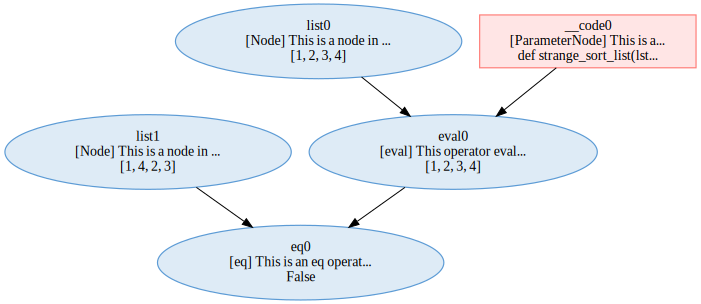

In [3]:
correctness = test_output.eq([1, 4, 2, 3])
correctness.backward("test failed", visualize=True, print_limit=25)

We are not just tracing how the program is run -- we are tracing how we verified the correctness of the output too, all without any manual intervention. Our design philosophy is to support un-interrupted Python programming.

```{note}
You may have noticed that we used `test_output.eq([1, 4, 2, 3])` instead of the more conventional `test_output == [1, 4, 2, 3]`. 
You can try it! Actually, both statements will execute without an error. However, `test_output == [1, 4, 2, 3]` returns a Python boolean object `False`, while `test_output.eq([1, 4, 2, 3])` returns a Trace `MessageNode`. We have taken great effor to make Node objects work just like any Python objects, but there are some corner cases to watch out for.
```

## Optimize with Feedback

We can use Trace and the optimizer defined in `opto.optimizers` to learn a program that can pass this test! But first, we need to provide some signal to the optimizer. We call this signal **feedback**. The more intelligent the optimizer is, the less guidance we need to give in the feedback. Think of this as us providing instructions to help LLM-based optimizers to come up with better solutions.

```{note}
You might be thinking -- `correctness` is already a boolean variable and has a name `correctness`. Why do we need to explicitly provide a feedback string to the optimizer? This is because just by `False` or `True` -- it is hard to know whether the test has passed or not. We could be testing on a positive or a negative target. Therefore, it is important to pass in an explicit feedback.
```

```{tip}
What do we have to write without Trace? If you are using a ChatGPT/Bard/Claude interface, you will copy paste the code into the interface, ask it to write code for you. Copy/paste the code back into a code editor that has Python runtime. Execute the Python code. Compare the output with the ground truth, and then write in the chat interface `test case failed!`. Trace simplified all of these steps.
```

In [7]:
def get_feedback(predict, target):
    if predict == target:
        return "test case passed!"
    else:
        return "test case failed!"

In order for the optimization code to run, create a file with name `OAI_CONFIG_LIST` in the same folder as this notebook. This file should look the same as [OAI_CONFIG_LIST](https://github.com/microsoft/autogen/blob/main/OAI_CONFIG_LIST_sample).

The code below looks like any PyTorch code. We can break it down to a few steps:
1. We first create an optimizer from `opto.optimizers.FunctionOptimizer`.
2. The bundled function `strange_sort_list` has a convenience method `.parameters()` for us to grab all the trainable parameters in it. In this case, the trainable parameter is just the function code itself.
3. We need to perform `backward` pass on a `MessageNode` object, which is `correctness`. We also need to pass in the `feedback` into the optimizer as well.
4. We call `optimizer.step()` to perform the actual optimization

In [14]:
import autogen
from opto.optimizers import FunctionOptimizer

test_ground_truth = [1, 4, 2, 3]
test_input = [1, 2, 3, 4]

epoch = 2

optimizer = FunctionOptimizer(strange_sort_list.parameters(), 
                              config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

for _ in range(epoch):
    test_output = strange_sort_list(test_input)
    correctness = test_output.eq(test_ground_truth)
    feedback = get_feedback(test_output, test_ground_truth)

    if correctness:
        break
    
    optimizer.zero_feedback()
    optimizer.backward(correctness, feedback)

    optimizer.step(verbose=True)

Prompt
 
You're tasked to solve a coding/algorithm problem. You will see the instruction, the code, the documentation of each function used in the code, and the feedback about the execution result.

Specifically, a problem will be composed of the following parts:
- #Instruction: the instruction which describes the things you need to do or the question you should answer.
- #Code: the code defined in the problem.
- #Documentation: the documentation of each function used in #Code. The explanation might be incomplete and just contain high-level description. You can use the values in #Others to help infer how those functions work.
- #Variables: the input variables that you can change.
- #Constraints: the constraints or descriptions of the variables in #Variables.
- #Inputs: the values of other inputs to the code, which are not changeable.
- #Others: the intermediate values created through the code execution.
- #Outputs: the result of the code output.
- #Feedback: the feedback about the code

```{note}
We can examine what the learned function look like by printing out its content below.
```

In [27]:
print(strange_sort_list.parameters()[0].data)

def strange_sort_list(lst):
    '''
    Given list of integers, return list in strange order.
    Strange sorting, is when you start with the minimum value,
    then maximum of the remaining integers, then minimum and so on.

    Examples:
    strange_sort_list([1, 2, 3, 4]) == [1, 4, 2, 3]
    strange_sort_list([5, 5, 5, 5]) == [5, 5, 5, 5]
    strange_sort_list([]) == []
    '''
    if not lst:
        return lst
    sorted_lst = sorted(lst)
    result = []
    while sorted_lst:
        result.append(sorted_lst.pop(0))
        if sorted_lst:
            result.append(sorted_lst.pop())
    return result


## The Optimized Function is Runnable

You might wonder -- oh, is this function actually changed? Yes it is. In fact, we can pass in a different test example and see if it worked.

In [23]:
new_test_input = [5, 3, 2, 5]
new_test_output = strange_sort_list(new_test_input)
print(new_test_output)

MessageNode: (eval:9, dtype=<class 'list'>, data=[2, 5, 3, 5])


## Save and Load the Optimized Function

In fact, just like PyTorch, you can easily save and load this function too. We will discuss more details in the next section.

In [24]:
strange_sort_list.save("strange_sort_list.pkl")

## Simple, Intuitive, But What's Next?

The functionalities provided by Trace seem simple and straightforward right now. But using these as basic building blocks, we can construct LLM-based workflow that is complex and mind-blowing. Continue to the next section to find out!